In [1]:
import sys
sys.path.append('../libs')


In [2]:
import numpy as np
import pandas as pd
import data_lib, plot_lib, decision_lib, validation_lib, transform_lib
from sklearn import cluster, mixture

np.random.seed(200)

In [3]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData
wa-sa-D3, files: 14                     wa-sa-A3, files: 13                     wa-sa-C3, files: 13
wa-sa-A5, files: 13                     wa-sa-A2, files: 14                     wa-sa-A1, files: 13
wa-sa-A4, files: 13                     wa-sa-D2, files: 13                     wa-sa-B5, files: 13
wa-sa-B1, files: 13                     wa-sa-D4, files: 13                     wa-sa-C2, files: 13
wa-sa-C5, files: 13                     wa-sa-B2, files: 13                     wa-sa-D5, files: 14
wa-sa-B4, files: 13                     wa-sa-B3, files: 13                     wa-sa-C4, files: 13
wa-sa-D1, files: 13                     wa-sa-C1, files: 13   

### Get samples for negative control

In [10]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                     #"wa-sa-A2", 
                                     #"wa-sa-B4",
                                     #"wa-sa-C4",
                                     #"wa-sa-B3",  
                                     #"wa-sa-B2",
                                     #"wa-sa-A5", 
                                     #"wa-sa-A3",
                                     #"wa-sa-C2",
                                     #"wa-sa-C3", # Pos
                                     #"wa-sa-D3", # Zero
                                     #"wa-sa-D4", 
                                     #"wa-sa-B1", 
                                     #"wa-sa-A4",
                                     #"wa-sa-A1", 
                                     #"wa-sa-D2",
                                     "wa-sa-C5", # Pos
                                     #"wa-sa-D5", # Zero
                                     #"wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [16]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
whitening_engine = transform_lib.WhitenTransformer()
num_cluster = int(2**len(prediction_axis) * 1.2)
num_cluster = 30
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
#cluster_engine = mixture.GaussianMixture(n_components=100)
decision = decision_lib.ClusterRelativeHierarchyMeanClassifier(
                                     cluster_algorithm=cluster_engine,
                                     #negative_control = np_negative_control,
                                     whitening_transformer=whitening_engine,
                                     negative_range=0.9,
                                     eps=0.4,
                                     contamination=0.0000000004,
                                     prediction_axis=prediction_axis
                                     )

In [17]:
df_decision = decision.predict(np_wa)

Epsilon: 0.4
Hierarchy: [0 1 1 1 1 2 1 1 0 3 3 3 3 2 2 0 1 3 2 1 2 0 4 2 2 2 2 2 1 2]


In [18]:
decision.neg_dimensions

array([False, False, False, False, False, False])

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive
- yellow = outlier

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 4.373496610540127e-05, n_outlier: 1

Total error rate: 0.0014724749241894098
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.000262      0.00258   0.004767   0.000437   0.000306 0.000481

Precision (TP / (TP + FP)): 0.9767663302228147
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0     0.961856   0.931878        1.0   0.994332      1.0

Recall / TPR (TP / (TP + FN)): 0.9846419658283739
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.993521     0.976963   0.971767   0.986979        1.0 0.952991

Specificity / TNR (TN / (TN + FP)): 0.9990755824966849
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0     0.998311   0.996416        1.0   0.999676      1.0

Accuracy ((TP + TN) / (P + N)): 0.9985275250758106
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999738      0.99742   0.995233   0.999563   0.999694 0.999519

F1 (2 * (precision * 

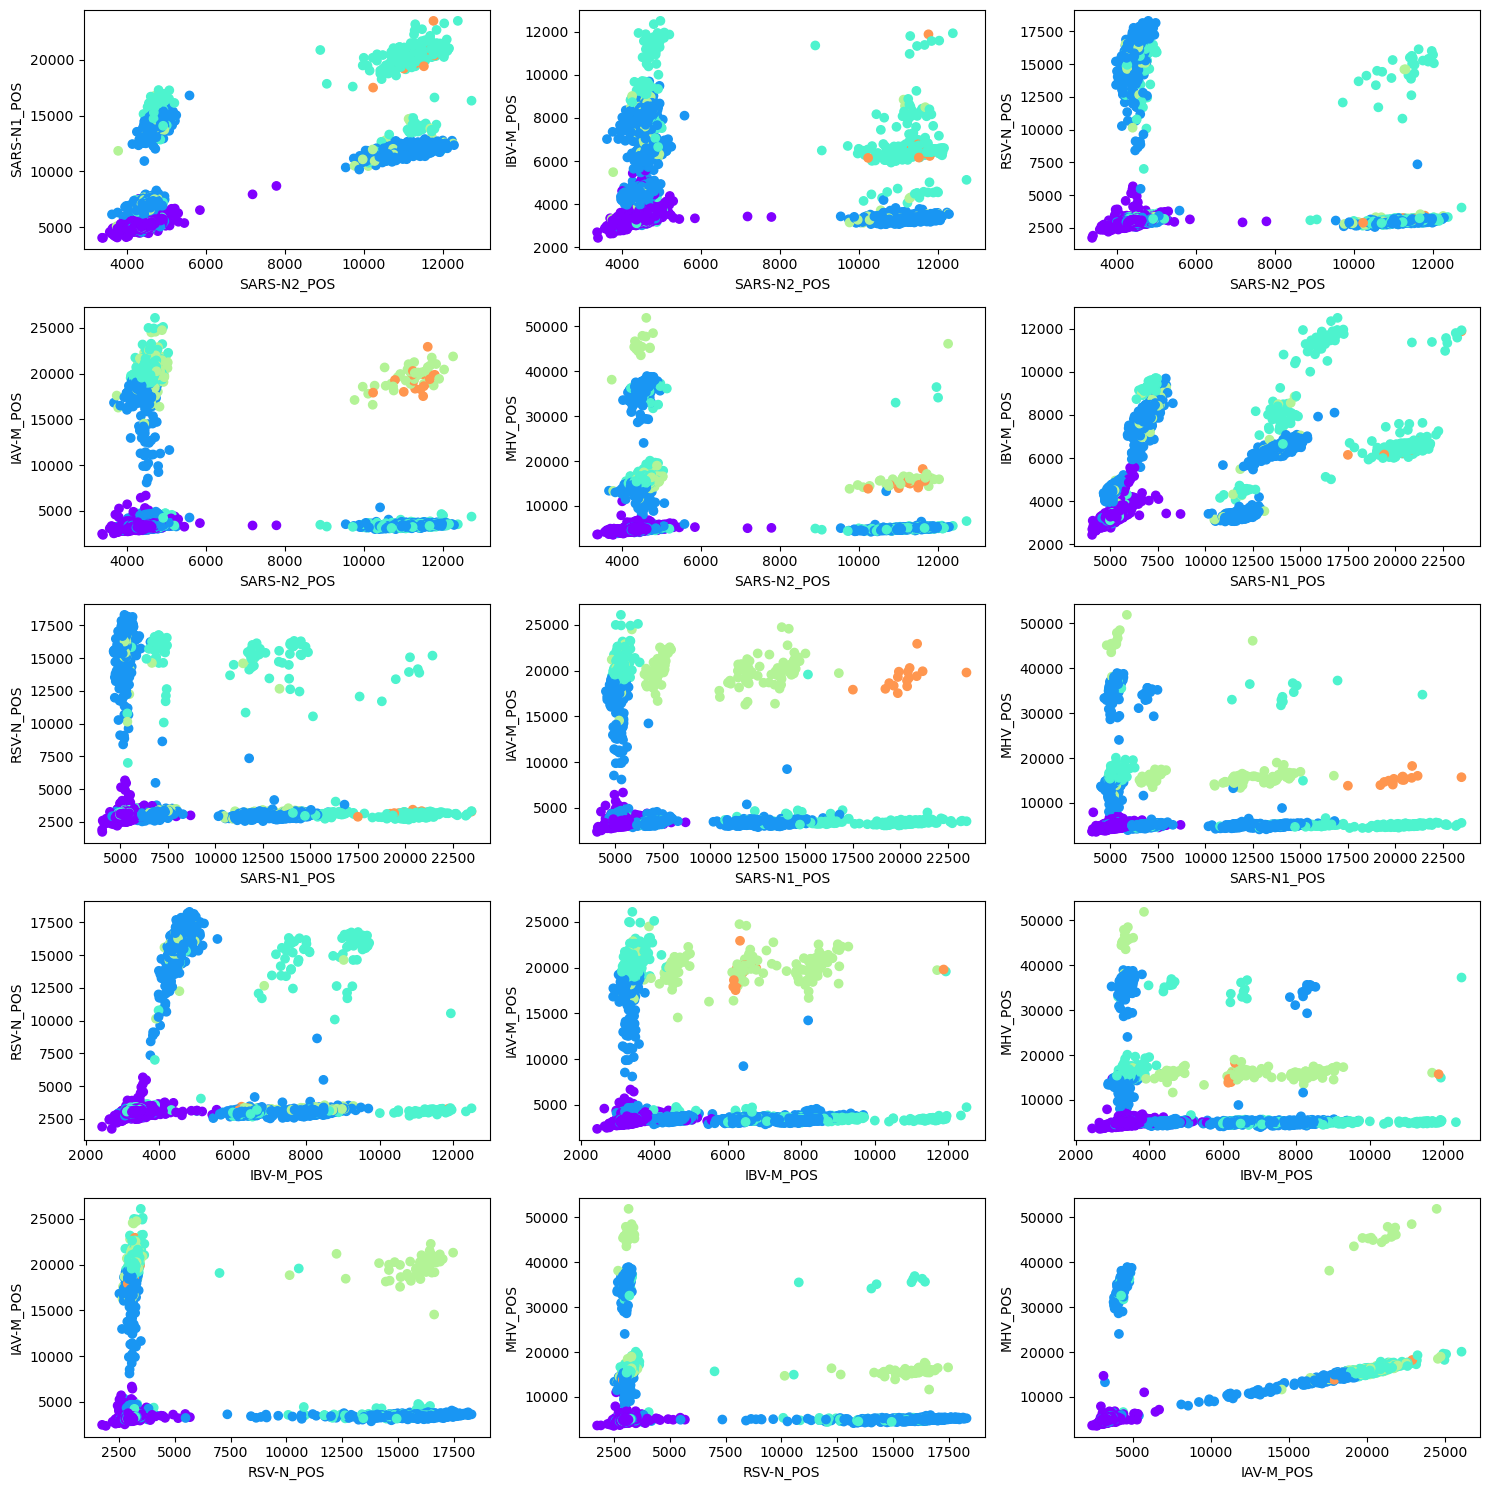

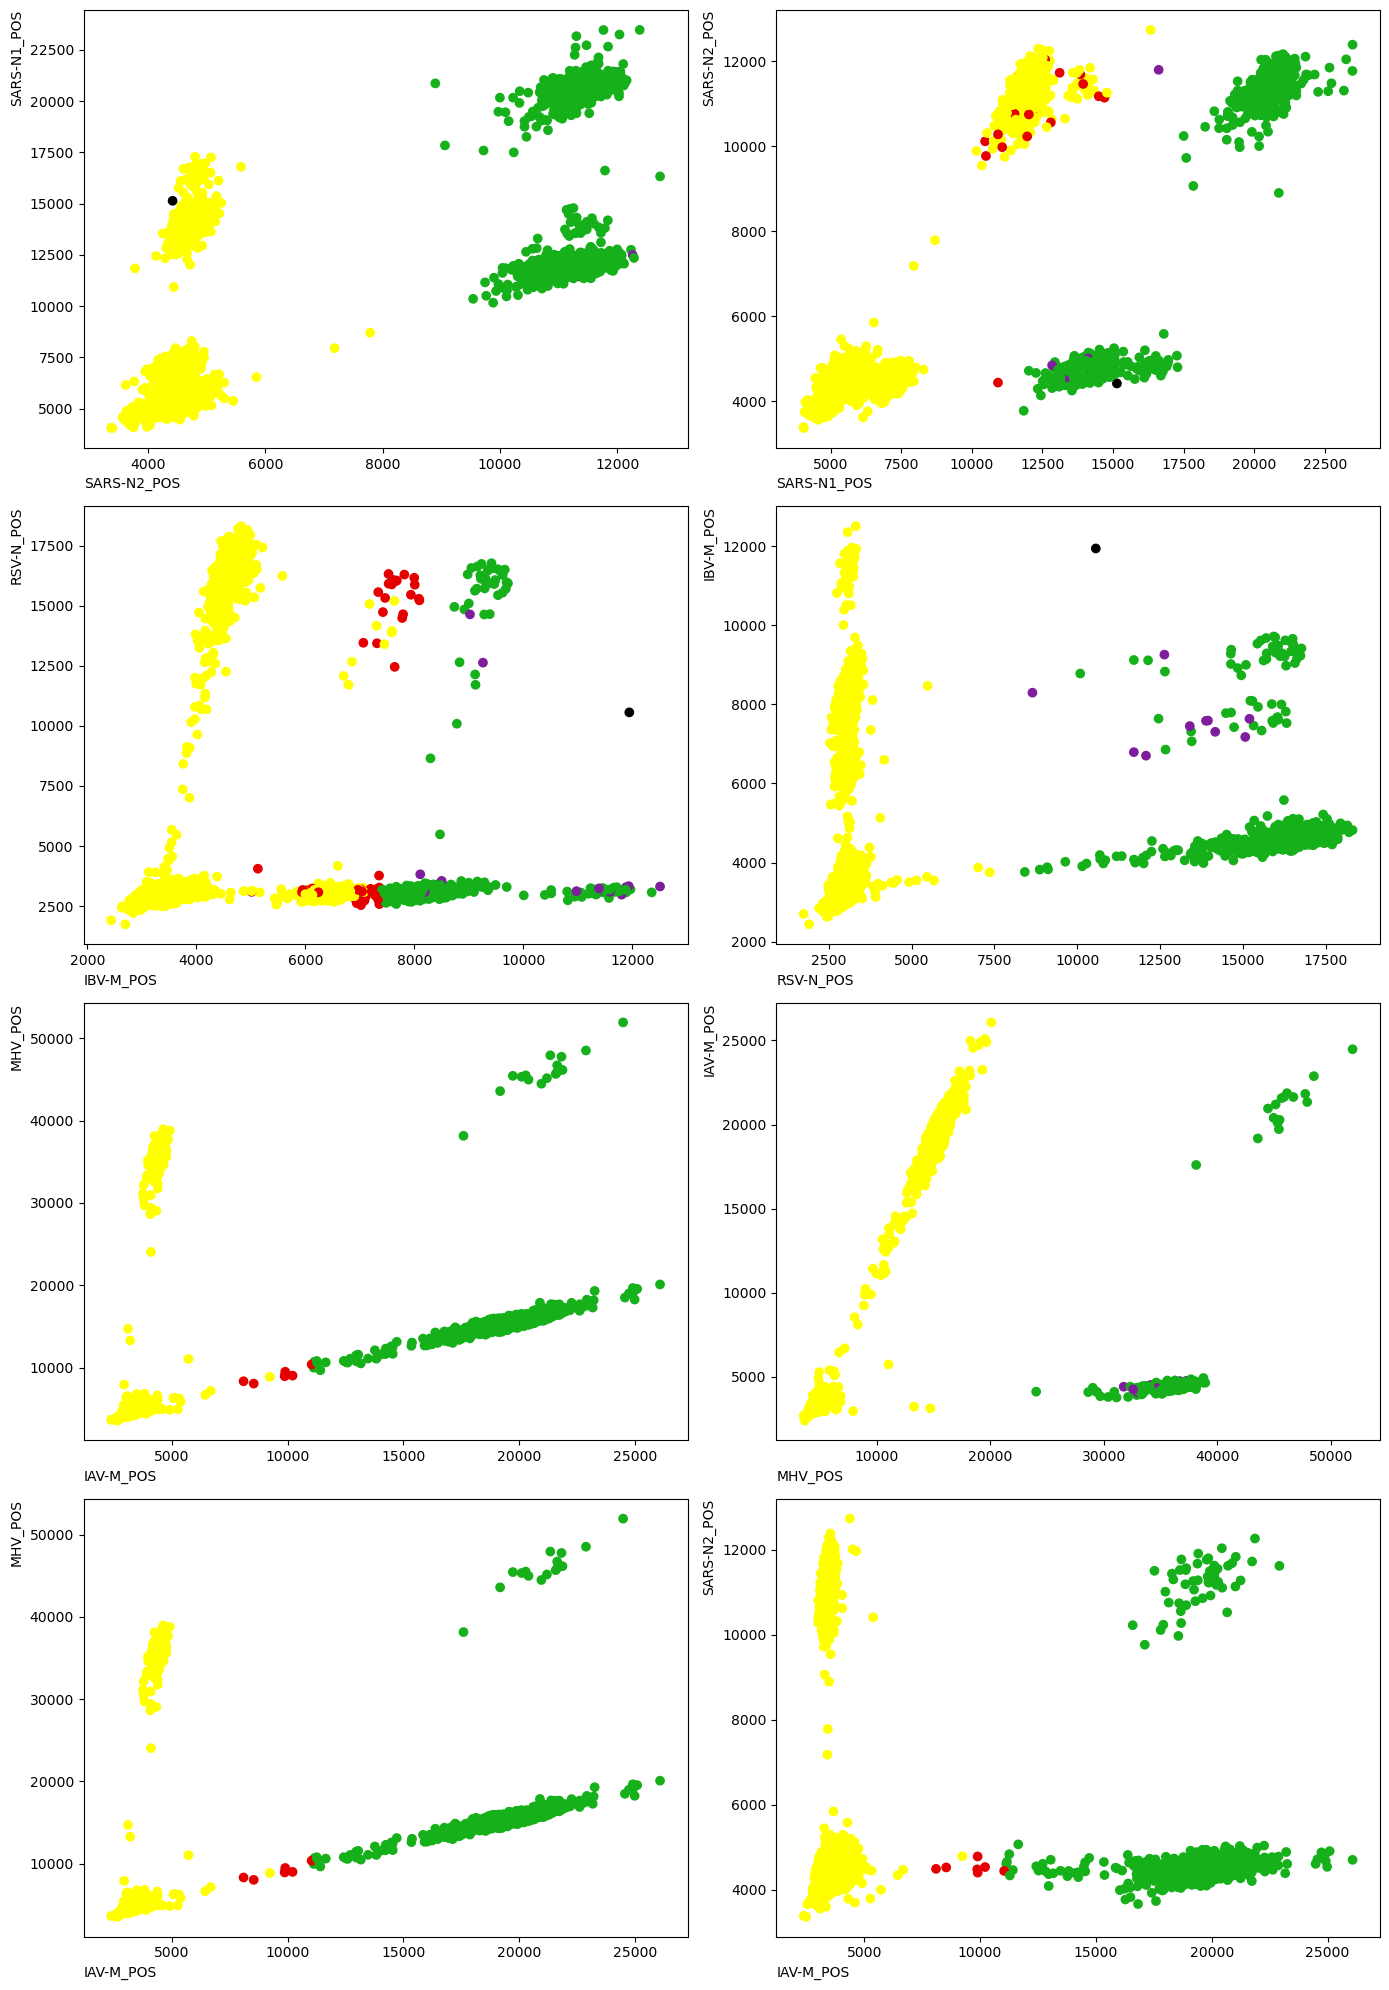

In [19]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = decision.predictions_df
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ('IAV-M_POS', 'MHV_POS'),
                ('IAV-M_POS', 'SARS-N2_POS'),
                ]
mask = decision.No_neg_mask

validation_lib.validate_labels(df_wa, df_decision)

plot_lib.pairwise_plots_label(df_data_points, decision.point_hierarchy)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=mask,
        )

### Error inspection

print only cluster with missclassifications

ic| cluster: 19, dim: 'IAV-M_POS', n_cluster - n_true: 7
ic| cluster: -1, dim: 'MHV_POS', n_cluster - n_true: 1
ic| cluster: 18, dim: 'MHV_POS', n_cluster - n_true: 11
ic| cluster: 9, dim: 'SARS-N1_POS', n_cluster - n_true: 1
ic| cluster: 10, dim: 'SARS-N1_POS', n_cluster - n_true: 33
ic| cluster: 18, dim: 'SARS-N1_POS', n_cluster - n_true: 2
ic| cluster: 24, dim: 'SARS-N1_POS', n_cluster - n_true: 20
ic| cluster: 26, dim: 'SARS-N1_POS', n_cluster - n_true: 1
ic| cluster: 27, dim: 'SARS-N1_POS', n_cluster - n_true: 1
ic| cluster: -1, dim: 'SARS-N2_POS', n_cluster - n_true: 1
ic| cluster: 9, dim: 'SARS-N2_POS', n_cluster - n_true: 2
ic| cluster: 11, dim: 'SARS-N2_POS', n_cluster - n_true: 1
ic| cluster: 18, dim: 'SARS-N2_POS', n_cluster - n_true: 3
ic| cluster: 5, dim: 'IBV-M_POS', n_cluster - n_true: 8
ic| cluster: 7, dim: 'IBV-M_POS', n_cluster - n_true: 53
ic| cluster: 9, dim: 'IBV-M_POS', n_cluster - n_true: 1
ic| cluster: 10, dim: 'IBV-M_POS', n_cluster - n_true: 3
ic| cluster: 12,

(Partially) falsely classified clusters [-1  5  7  9 10 11 12 16 17 18 19 22 24 26 27]


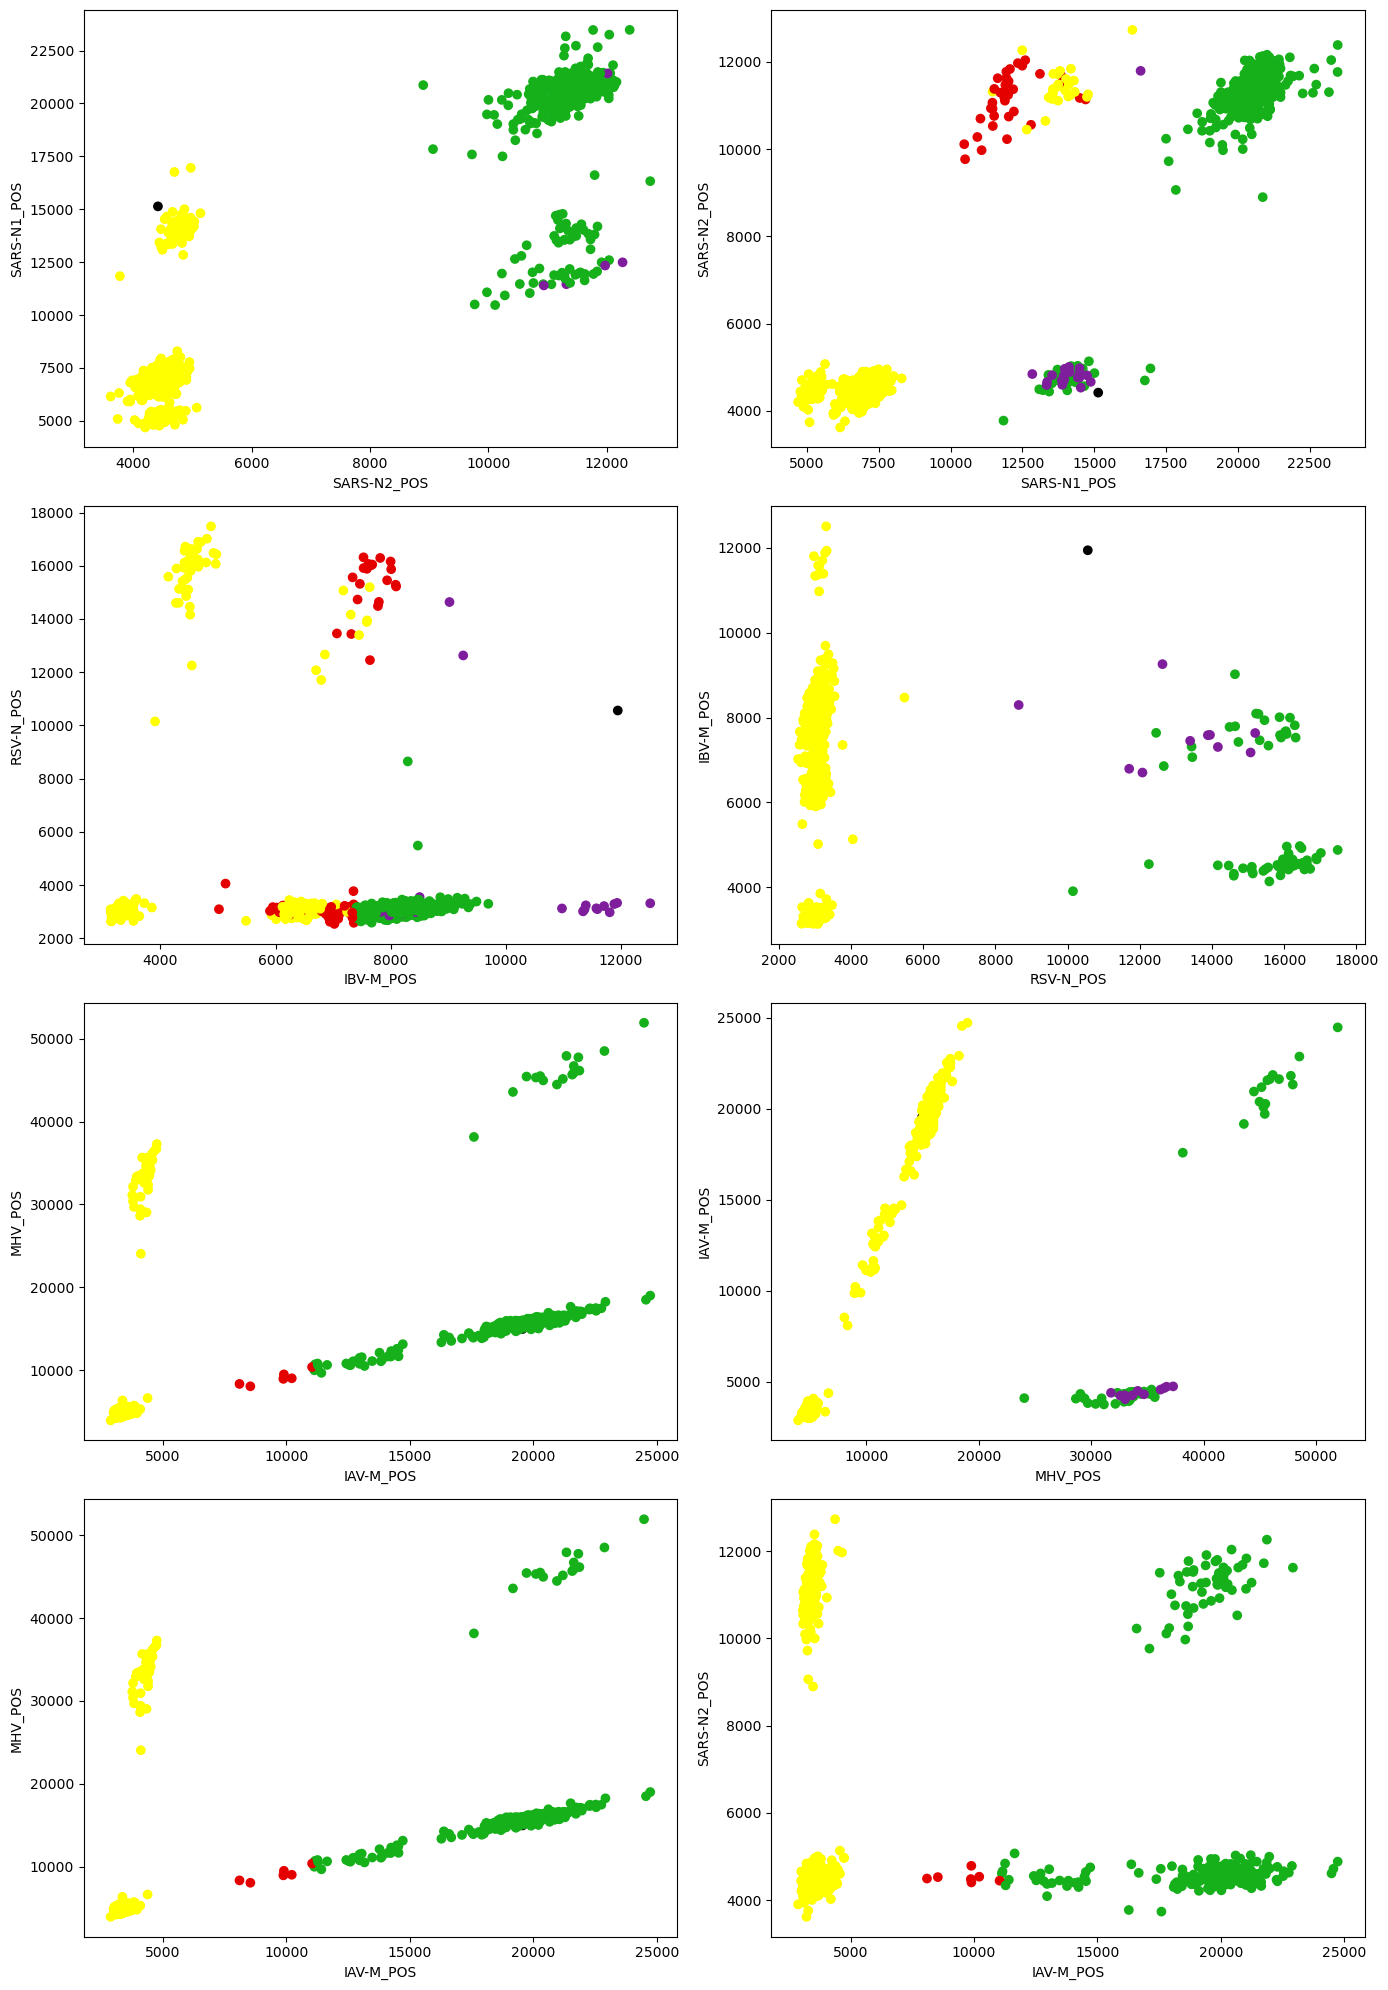

In [20]:
diseases = ["IAV-M_POS", "MHV_POS", "SARS-N1_POS", "SARS-N2_POS", "IBV-M_POS", "RSV-N_POS"]
false_clusters = validation_lib.get_false_clusters(clusters=decision.cluster_dict,
                                  df_true_labels=df_ground_trouth,
                                  df_predictions=df_predictions,
                                  disease=diseases,
                                  threshold=0.99)
df_false_data, df_false_predictions, df_false_ground_truth = validation_lib.get_false_cluster_for_plotting(df_data_points=df_data_points,
                                                                                                           df_predictions=df_predictions,
                                                                                                           df_ground_truth=df_ground_trouth,
                                                                                                           clusters=decision.cluster_dict,
                                                                                                           false_clusters=false_clusters)
print(f"(Partially) falsely classified clusters {false_clusters}")
plot_lib.plot_pairwise_selection(data_points=df_false_data, selected_pairs=selected_pairs, predictions=df_false_predictions, ground_trouth=df_false_ground_truth)